In [1]:
#importing all the libraries
import pandas as pd;
import re;
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import joblib


In [2]:
#load each dataset
fake_df = pd.read_csv("Fake.csv");
real_df = pd.read_csv("True.csv");

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
fake_df["subject"].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

In [63]:
import seaborn as sns

<Axes: xlabel='subject', ylabel='count'>

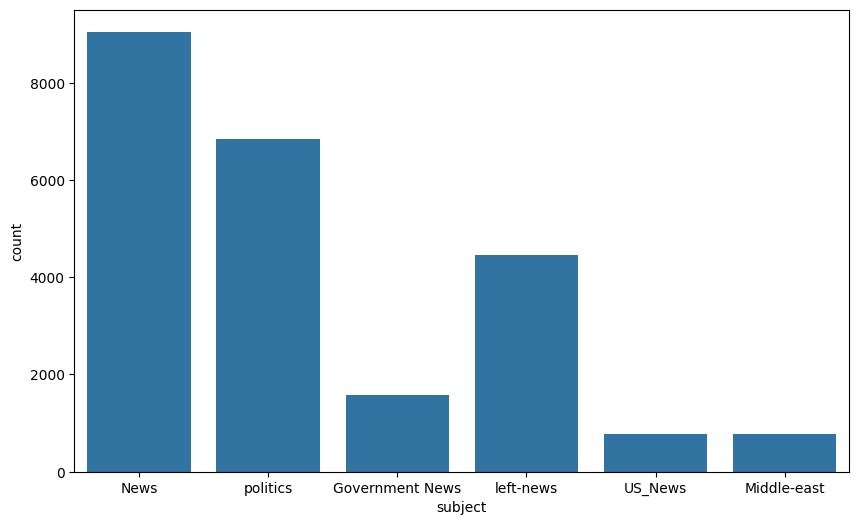

In [64]:
plt.figure(figsize=(10,6))
sns.countplot(x = "subject", data = fake_df)

## WordCloud

In [65]:
text = " ".join(fake_df["text"].tolist())

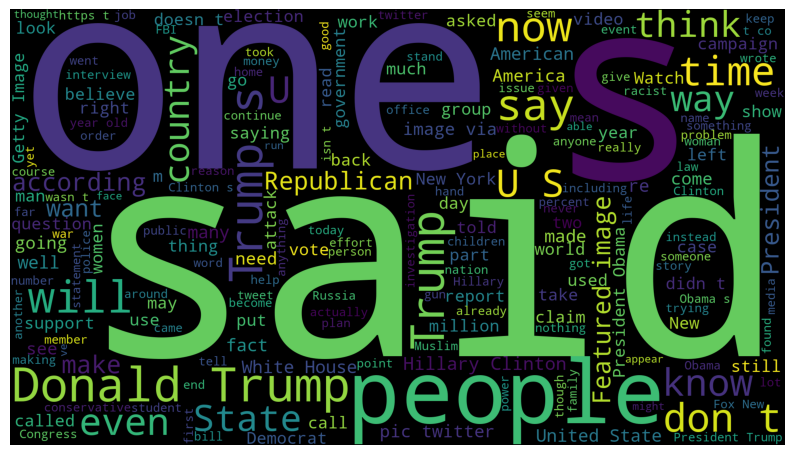

In [66]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Real News

In [67]:
real_df["subject"].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

In [68]:
text = " ".join(real_df["text"].tolist())

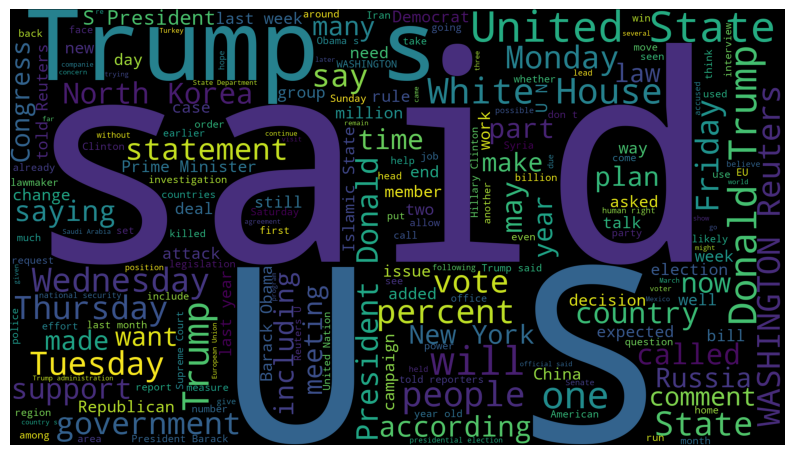

In [69]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [70]:
print(real_df["title"][2922])

Factbox: Trump on Twitter - Media, American troops, Stock market


In [71]:
unknown_publishers = []
for index, row in enumerate(real_df.text.values):
    try:
        record = row.split(" - ")
        record[1]
        assert(len(record[0])<120)
    except:
        unknown_publishers.append(index)

In [72]:
print(len(unknown_publishers))

229


In [73]:
real_df.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 229, dtype: object

In [74]:
publisher = []
tmp_text = []
for index, row in enumerate(real_df.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append("Unknown")
    else:
        record = row.split(" - ", maxsplit =1)
        publisher.append(record[0])
        tmp_text.append(record[1])

In [75]:
real_df["publisher"] = publisher
real_df["text"] = tmp_text

In [76]:
real_df.shape

(21417, 5)

In [77]:
empty_fake_index = [index for index,text in enumerate(fake_df.text.tolist()) if str(text).strip()==""]

In [78]:
empty_fake_index[0]

10923

In [79]:
real_df["text"] = real_df["title"] + " " + real_df["text"]
fake_df["text"] = fake_df["title"] + " " + fake_df["text"]

In [80]:
fake_df["text"][10923]

'TAKE OUR POLL: Who Do You Think President Trump Should Pick To Replace James Comey?  '

In [81]:
real_df["text"]

0        As U.S. budget fight looms, Republicans flip t...
1        U.S. military to accept transgender recruits o...
2        Senior U.S. Republican senator: 'Let Mr. Muell...
3        FBI Russia probe helped by Australian diplomat...
4        Trump wants Postal Service to charge 'much mor...
                               ...                        
21412    'Fully committed' NATO backs new U.S. approach...
21413    LexisNexis withdrew two products from Chinese ...
21414    Minsk cultural hub becomes haven from authorit...
21415    Vatican upbeat on possibility of Pope Francis ...
21416    Indonesia to buy $1.14 billion worth of Russia...
Name: text, Length: 21417, dtype: object

In [82]:
real_df["text"] = real_df["text"].apply(lambda x: str(x).lower())

In [83]:
fake_df["text"] = fake_df["text"].apply(lambda x: str(x).lower())

In [84]:
real_df.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...","as u.s. budget fight looms, republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,u.s. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior u.s. republican senator: 'let mr. muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [85]:
#adding label 0 for fake and 1 for true
real_df["label"] = 1
fake_df["label"] = 0

In [88]:
real_df.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'label'], dtype='object')

In [89]:
#dropping extra columns from fake dataset
fake_df = fake_df.drop(["title", "subject", "date"],axis=1)

In [90]:
#dropping extra columns from true dataset
real_df = real_df.drop(["title", "subject", "date", "publisher"],axis=1)

In [93]:
fake_df.head()

,text,label
0,donald trump sends out embarrassing new year’...,0
1,drunk bragging trump staffer started russian ...,0
2,sheriff david clarke becomes an internet joke...,0
3,trump is so obsessed he even has obama’s name...,0
4,pope francis just called out donald trump dur...,0


In [94]:
real_df.head()

,text,label
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


In [95]:
#merging two datasets
df = pd.concat([fake_df, real_df],).reset_index(drop=True)

In [96]:
df.head()

,text,label
0,donald trump sends out embarrassing new year’...,0
1,drunk bragging trump staffer started russian ...,0
2,sheriff david clarke becomes an internet joke...,0
3,trump is so obsessed he even has obama’s name...,0
4,pope francis just called out donald trump dur...,0


In [97]:
df.tail()

,text,label
44893,'fully committed' nato backs new u.s. approach...,1
44894,lexisnexis withdrew two products from chinese ...,1
44895,minsk cultural hub becomes haven from authorit...,1
44896,vatican upbeat on possibility of pope francis ...,1
44897,indonesia to buy $1.14 billion worth of russia...,1


In [98]:
#shuffling the dataset
df = df.sample(frac=1)

In [99]:
df.head()

,text,label
44708,heavy civilian casualties in raqqa from air st...,1
23934,factbox: trump on twitter (nov 30) - nytimes t...,1
6732,henry rollins destroys north carolina’s gop g...,0
1001,former gop rep throws support behind obamacar...,0
38277,zimbabwe army detains finance minister: govern...,1


In [100]:
df.tail()

,text,label
6160,cnn accidentally airs raunchy screen capture ...,0
3810,"obama takes pity on trump, plans to hold his ...",0
35249,earthquake of magnitude 5.2 strikes near iran'...,1
30333,trump to pick foe of obama climate agenda to r...,1
35421,vietnam orders prosecution of oil firm officia...,1


In [101]:
df = df.reset_index(drop=True)

In [102]:
df.head()

,text,label
0,heavy civilian casualties in raqqa from air st...,1
1,factbox: trump on twitter (nov 30) - nytimes t...,1
2,henry rollins destroys north carolina’s gop g...,0
3,former gop rep throws support behind obamacar...,0
4,zimbabwe army detains finance minister: govern...,1


In [103]:
df.tail()

,text,label
44893,cnn accidentally airs raunchy screen capture ...,0
44894,"obama takes pity on trump, plans to hold his ...",0
44895,earthquake of magnitude 5.2 strikes near iran'...,1
44896,trump to pick foe of obama climate agenda to r...,1
44897,vietnam orders prosecution of oil firm officia...,1


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [105]:
df["text"][0]

'heavy civilian casualties in raqqa from air strikes: u.n. civilians caught up in the battle for the syrian city of raqqa are paying an  unacceptable price  and attacking forces may be contravening international law with their intense air strikes, the top united nations human rights official said on thursday. a u.s.-led coalition is seeking to oust islamic state from raqqa, while syrian government forces, backed by the russian air force and iran-backed militias are also advancing on the city. some 20,000 civilians are trapped in raqqa where the jihadist fighters are holding some of them as human shields, the world body says. u.n. high commissioner for human rights zeid ra ad al-hussein said that his office had documented 151 civilian deaths in six incidents alone in august, due to air strikes and ground-based attacks.  given the extremely high number of reports of civilian casualties this month and the intensity of the air strikes on raqqa, coupled with isil s use of civilians as human

In [106]:
#remove special characters and punctuation

In [107]:
stop_words = set(stopwords.words("english"))

lemmatizer = WordNetLemmatizer()

# Map POS tags to WordNet tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

#function for removing the special characters and punctuation
def clean_text(text):
     # 1. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # 2. Remove special characters (but keep spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    #3 lowercase 
    text = text.lower();
    
    # 4. Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # 5. Strip leading and trailing spaces
    text = text.strip()
    
     # 6. Tokenize and POS tag
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    
    # 7. Lemmatize and remove stopwords
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged_tokens if word not in stop_words
    ]
    
    return " ".join(lemmatized)

In [108]:
df["text"] = df["text"].apply(clean_text)

In [109]:
df.head()

,text,label
0,heavy civilian casualty raqqa air strike un ci...,1
1,factbox trump twitter nov 30 nytimes following...,1
2,henry rollins destroys north carolina gop gove...,0
3,former gop rep throw support behind obamacare ...,0
4,zimbabwe army detain finance minister governme...,1


In [110]:
df["text"][0]

'heavy civilian casualty raqqa air strike un civilian catch battle syrian city raqqa pay unacceptable price attack force may contravene international law intense air strike top united nation human right official say thursday usled coalition seek oust islamic state raqqa syrian government force back russian air force iranbacked militia also advance city 20000 civilian trap raqqa jihadist fighter hold human shield world body say un high commissioner human right zeid ra ad alhussein say office document 151 civilian death six incident alone august due air strike groundbased attack give extremely high number report civilian casualty month intensity air strike raqqa couple isil use civilian human shield deeply concerned civilian protect time pay unacceptable price force involve battle isil lose sight ultimate goal battle zeid say statement attacking force may fail abide international humanitarian law principle precaution distinction proportionality say usled coalition say conduct nearly 1100

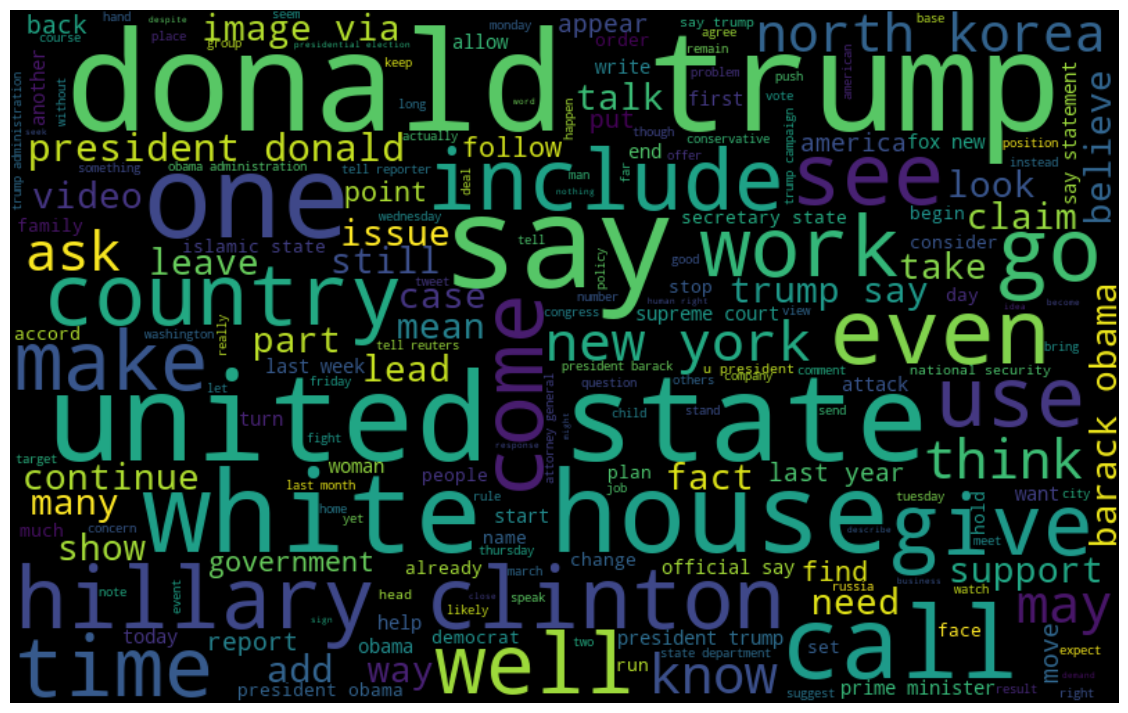

In [111]:
#visualize the frequent words
all_words = " ".join([sentence for sentence in df["text"]])
wordcloud = WordCloud(width=800, height=500, random_state = 42, max_font_size=100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

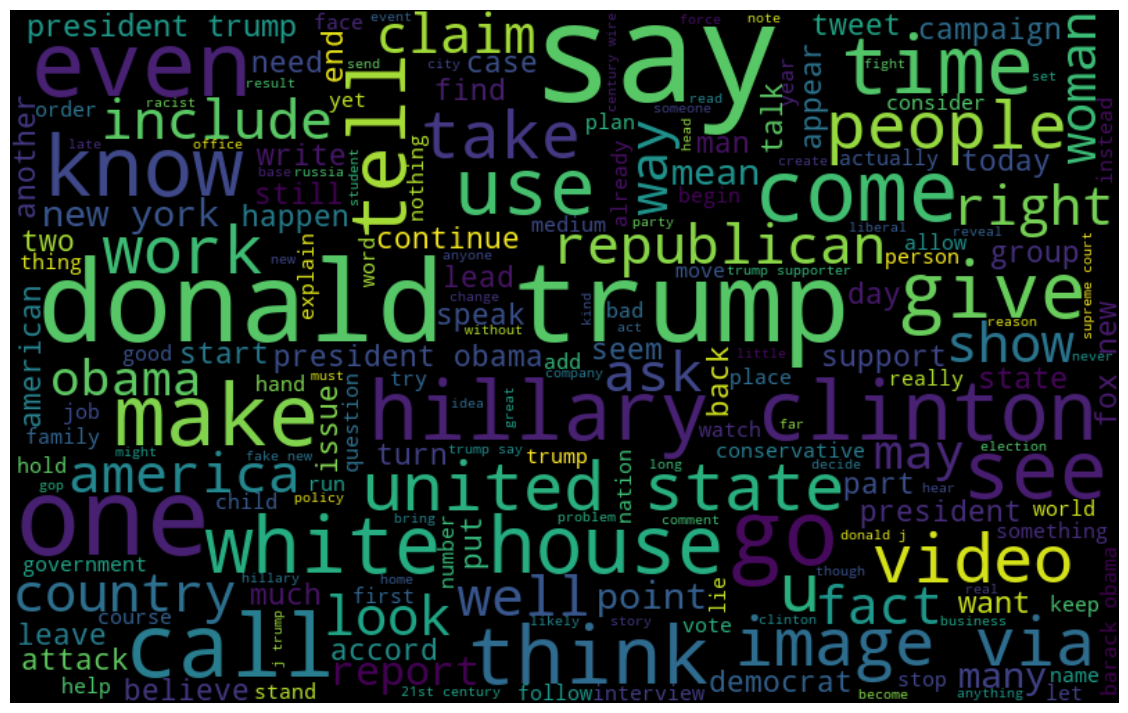

In [112]:
#visualize the frequent words for fake news
all_words = " ".join([sentence for sentence in df["text"][df["label"] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state = 42, max_font_size=100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

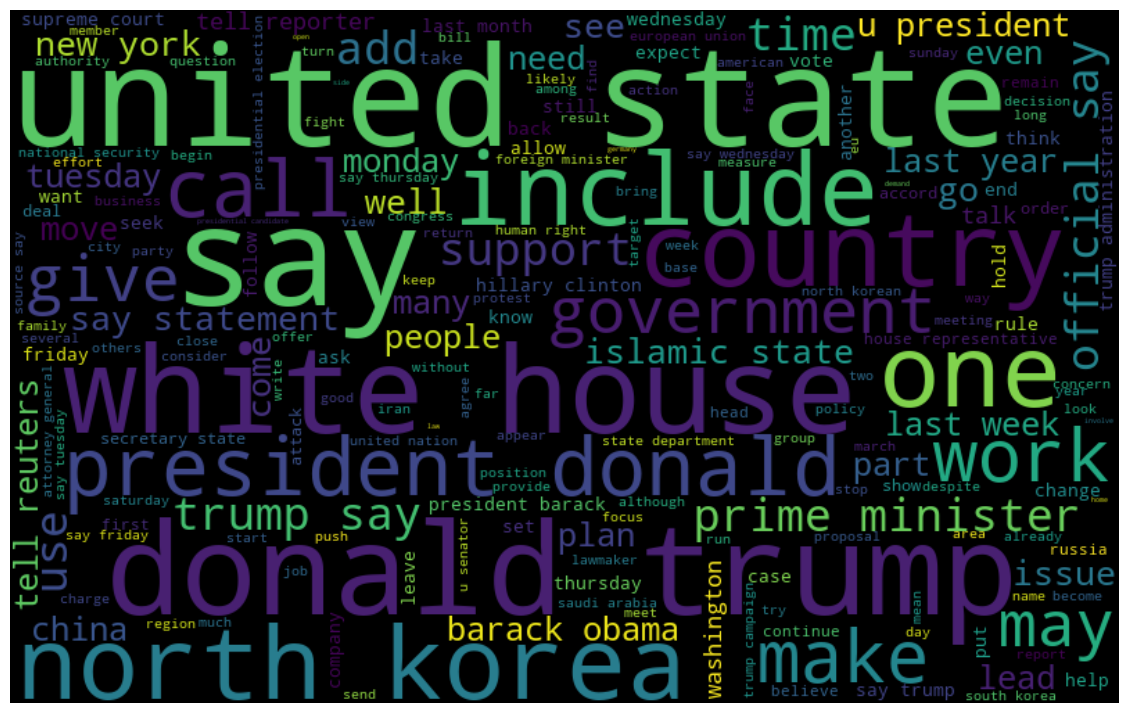

In [113]:
#visualize the frequent words for real news
all_words = " ".join([sentence for sentence in df["text"][df["label"] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state = 42, max_font_size=100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Vectorization

In [117]:
#vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

#fit and transform text data
X = vectorizer.fit_transform(df["text"])
Y = df["label"]
print(X.shape)
print(Y.shape)

(44898, 10000)
(44898,)


## Train_Test_Split

In [120]:
#train test and split
#splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [29]:
#train the model with naive bayes
nb = MultinomialNB();
nb.fit(X_train, Y_train)
Y_pred = nb.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("accuracy:", accuracy)

accuracy: 0.960913140311804


In [30]:
#checking confusion matrix

cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[4136  126]
 [ 225 4493]]


In [31]:
#checking f1, recall and precision score
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4262
           1       0.97      0.95      0.96      4718

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



## Training with Logistic Regression

In [123]:
#train the model with Logistic Regression
lr = LogisticRegression()
lr.fit(X_train,Y_train)
Y_pred = lr.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("accuracy:", accuracy)

accuracy: 0.9806236080178173


In [124]:
#checking confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[4540   95]
 [  79 4266]]


In [125]:
#checking f1, recall and precision score
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4635
           1       0.98      0.98      0.98      4345

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



## Training with Random Forest Classifier

In [129]:
#train the model with Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_predict = rfc.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

0.9806236080178173


In [130]:
#checking confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[4540   95]
 [  79 4266]]


In [131]:
#checking f1, recall and precision score
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4635
           1       0.98      0.98      0.98      4345

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



## Training with XGBoost Classifier

In [134]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, Y_train)
Y_predict = xgb.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

0.9806236080178173


In [137]:
ensemble = VotingClassifier(
    estimators = [("lr", lr), ("rfc", rfc), ("xgb", xgb)],
    voting = "soft"
)
ensemble.fit(X_train, Y_train)
Y_predict = ensemble.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

0.9806236080178173


In [138]:
joblib.dump(ensemble, "vc_model.pkl")

['vc_model.pkl']

In [139]:
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [1]:
import tensorflow as tf

In [7]:
from keras_preprocessing.text import Tokenizer

In [27]:
tokenizer = Tokenizer(num_words=10000, oov_token="<unk>")

In [22]:
sentences = ["THis is a good boy"]

In [23]:
print(tokenizer)

In [24]:
tokenizer.

In [25]:
sequences = tokenizer.texts_to_sequences(sentence)

In [26]:
print(sequences)

[[None, None, None, None, None]]
